In [27]:
import numpy as np
import matplotlib.pyplot as plt
import heapq
import random
import time
import copy
import sys
sys.setrecursionlimit(10000)

In [28]:
# constants

maze_dims = 101
num_trials = 50

In [29]:
# common utility / helper functions

# this function computes the Manhattan distance between coordinates a and b in the maze
def compute_manhattan_distance(a, b):
	return abs(b[0] - a[0]) + abs(b[1] - a[1]);

In [30]:
# this class implements a node that will be stored in the open or closed list 
# during the A* search; corresponds to a cell in the maze

class Node():
	# class constructor
	def __init__(self, parent=None, position=None, tiebreak='larger'):
		self.parent = parent    # parent node to this node
		self.position = position    # coordinates of this node on the maze

		self.g = 0  # g value till this node for a given start and end
		self.h = 0  # h value from this node for a given start and end
		self.f = 0  # f value at this node for a given start and end

		# defines priority rule for g values when f values are tied: 'larger' or 'smaller'
		self.tiebreak = tiebreak   

	# function to compare whether two nodes correspond to the same cell in the maze
	def __eq__(self, other):
		return self.position == other.position

	# function to define ordering between two nodes based on their f score
	def __lt__(self, other):
		if self.f == other.f:
			# tie break for equal f values
			if ((self.tiebreak == 'larger') and (self.g > other.g)) \
				or ((self.tiebreak == 'smaller') and (self.g < other.g)):
				return True 
		elif self.f < other.f:
			return True

In [31]:
# this class generates a maze with randomly chosen blocked and unblocked cells,
# and initializes two unblocked cells as source and goal states 

class Maze:
	# class constructor
	def __init__(self, rows, columns, prob_block):
		# generate 2D matrix of 0s (unblocked cells) and 1s (blocked cells),
		# such that probability of a cell being blocked = prob_block
		self.grid = np.random.choice(
						a=[0, 1],
						size=(rows, columns),
						p=[1-prob_block,prob_block])

		# set cells corresponding to (row = 0, column = 0) and 
		# (row = 100, column = 100) in the maze as unblocked;
		# these are used as default source and goal respectively,
		# if the source and goal arguments are invalid
		self.grid[0][0] = 0
		self.grid[rows-1][columns-1] = 0

		self.rows = rows
		self.cols = columns
		self.prob_block = prob_block


	# this function visualizes the created maze
	def show_plot(self):
		plt.figure(figsize=(15, 25))
		plt.imshow(self.grid, cmap='Greys', interpolation='nearest')
		plt.show()

	# this function checks if the cell at the given coordinates is blocked
	def is_blocked(self,px,py):
		return self.grid[px][py]==1
		
	# this function sets the source state where the agent is placed initially
	def source(self,px,py):
		if self.is_blocked(px, py):
			print('source coordinates correspond to a blocked cell, setting to default')
			return (0,0)
		else:
			return (px,py)
	
	# this function sets the goal state where the agent needs to reach finally
	def goal(self,px,py):
		if self.is_blocked(px, py):
			print('goal coordinates correspond to a blocked cell, setting to default')
			return (self.rows-1,self.cols-1)
		else:
			return (px,py)

In [61]:
# this class implements the A* algorithm for finding shortest path
# from a given source cell to goal cell in a gridworld/maze

class AStar():
	# class constructor
	def __init__(self, maze=None, start=None, end=None, version='forward', tiebreak='larger'):
		# defines state space for the search problem
		self.maze = maze  

		# coordinates of the source cell in the maze   
		self.start = start

		# coordinates of the goal cell in the maze
		self.end = end  

		# defines search strategy for A*: 'forward', 'backward' or 'adaptive'  
		self.version = version   

		# defines priority rule for g values when f values are tied: 'larger' or 'smaller'
		self.tiebreak = tiebreak   

		# keeps track of the number of expanded nodes during the search for performance evaluation
		self.num_expanded_nodes = 0 

	# this function returns a list of tuples, including a path from a given source cell to a goal cell
	# in the mental maze, using A* search algorithm
	def search(self, g_values_prev):
		# create start and end nodes
		start_node = Node(None, self.start, tiebreak=self.tiebreak)
		start_node.g = start_node.h = start_node.f = 0
		end_node = Node(None, self.end, tiebreak=self.tiebreak)
		end_node.g = end_node.h = end_node.f = 0

		open_heap = []      # holds the neighbors of expanded nodes in the search tree; stored as a heap
		closed_list = []    # holds the expanded nodes in the search tree

		neighbors = [(0,1),(0,-1),(1,0),(-1,0)]     # adjacent cell positions for a given cell

		# Forward A*
		if self.version == 'forward':
			visited_node = start_node

			# add the start node to the open list (heap) 
			heapq.heappush(open_heap, start_node)

			# explore until reaching the goal state or concluding that the goal is not reachable
			while len(open_heap) > 0:
				''' get the current node from the open list (root of the heap);
					neighbor of the last visited node,
					with least f-value (or larger/smaller g-value in case of a tie) '''
				current_node = heapq.heappop(open_heap) 	
				self.num_expanded_nodes = self.num_expanded_nodes + 1

				# found the goal
				if current_node == end_node:
					path = []
					current = visited_node

					# retrace the path from the goal to the source
					while current is not None:
						path.append(current.position)
						current = current.parent
					return (path[::-1], self.num_expanded_nodes, g_values_prev)

				# add current node to the closed list (mark the node visited)
				closed_list.append(current_node)
				visited_node = current_node

				# explore neighbors of the current cell
				for pos_x, pos_y in neighbors: 
					# get neighboring coordinates
					neighbor = (current_node.position[0] + pos_x, \
						current_node.position[1] + pos_y)

					# make sure the neighboring cell is part of the gridworld and unblocked
					if neighbor[0] > (len(self.maze) - 1) \
						or neighbor[0] < 0 \
						or neighbor[1] > (len(self.maze[0]) -1) \
						or neighbor[1] < 0 \
						or (self.maze[neighbor[0]][neighbor[1]] != 0):
						continue 

					# create node for valid neighboring cell
					neighbor_node = Node(current_node, neighbor, tiebreak=self.tiebreak)

					# make sure the node is not already expanded
					if (neighbor_node in closed_list) or (neighbor_node in open_heap):
						continue

					# compute g, h and f values for the node
					neighbor_node.g = current_node.g + 1
					neighbor_node.h = compute_manhattan_distance( \
						end_node.position, neighbor_node.position)  # Manhattan distance as the heuristic
					neighbor_node.f = neighbor_node.g + neighbor_node.h
					
					# add neighbor node to the open list (heap)
					heapq.heappush(open_heap, neighbor_node)

			print("the desired goal is not reachable from the given source")
			return ([], self.num_expanded_nodes, g_values_prev)


		# Backward A*
		if self.version == 'backward':
			visited_node = start_node
			
			# add the end node to the open list (heap)
			heapq.heappush(open_heap, end_node)

			# explore until reaching the goal state or concluding that the goal is not reachable
			while len(open_heap) > 0:
				''' get the current node from the open list (root of the heap);
					neighbor of the last visited node,
					with least f-value (or larger/smaller g-value in case of a tie) '''
				current_node = heapq.heappop(open_heap)
				self.num_expanded_nodes = self.num_expanded_nodes + 1

				# found the goal
				if current_node == start_node:
					path = []
					current = visited_node

					# retrace the path from the source to the goal
					while current is not None:
						path.append(current.position)
						current = current.parent
					return (path, self.num_expanded_nodes, g_values_prev)

				# add current node to the closed list (mark the node visited)
				closed_list.append(current_node)
				visited_node = current_node

				# explore neighbors of the current cell
				for pos_x, pos_y in neighbors: 
					# get neighboring coordinates
					neighbor = (current_node.position[0] + pos_x, \
						current_node.position[1] + pos_y)

					# make sure the neighboring cell is part of the gridworld and unblocked
					if neighbor[0] > (len(self.maze) - 1) \
						or neighbor[0] < 0 \
						or neighbor[1] > (len(self.maze[0]) -1) \
						or neighbor[1] < 0 \
						or (self.maze[neighbor[0]][neighbor[1]] != 0):
						continue 

					# create node for valid neighboring cell
					neighbor_node = Node(current_node, neighbor, tiebreak=self.tiebreak)

					# make sure the node is not already expanded
					if (neighbor_node in closed_list) or (neighbor_node in open_heap):
						continue

					# compute g, h and f values for the node
					neighbor_node.g = current_node.g + 1
					neighbor_node.h = compute_manhattan_distance( \
						start_node.position, neighbor_node.position)    # Manhattan distance as the heuristic
					neighbor_node.f = neighbor_node.g + neighbor_node.h
					
					# add neighbor node to the open list (heap)
					heapq.heappush(open_heap, neighbor_node)

			print("the desired goal is not reachable from the given source")
			return ([], self.num_expanded_nodes, g_values_prev)


		# Adaptive A*
		if self.version == 'adaptive':
			g_values = {} 	# keeps track of the g-values of expanded nodes during the search

			visited_node = start_node

			# add the start node to the open list (heap) 
			heapq.heappush(open_heap, start_node)

			# explore until reaching the goal state or concluding that the goal is not reachable
			while len(open_heap) > 0:
				''' get the current node from the open list (root of the heap);
					neighbor of the last visited node,
					with least f-value (or larger/smaller g-value in case of a tie) '''
				current_node = heapq.heappop(open_heap) 	
				self.num_expanded_nodes = self.num_expanded_nodes + 1

				# found the goal
				if current_node == end_node:
					path = []
					current = visited_node
					g_values[current_node.position] = current_node.g

					# retrace the path from the goal to the source
					while current is not None:
						path.append(current.position)
						current = current.parent
						g_values_prev = g_values 	# return previous g-values for the next call
					return (path[::-1], self.num_expanded_nodes, g_values_prev)

				# add current node to the closed list (mark the node visited)
				closed_list.append(current_node)
				visited_node = current_node

				# explore neighbors of the current cell
				for pos_x, pos_y in neighbors: 
					# get neighboring coordinates
					neighbor = (current_node.position[0] + pos_x, \
						current_node.position[1] + pos_y)

					# make sure the neighboring cell is part of the gridworld and unblocked
					if neighbor[0] > (len(self.maze) - 1) \
						or neighbor[0] < 0 \
						or neighbor[1] > (len(self.maze[0]) -1) \
						or neighbor[1] < 0 \
						or (self.maze[neighbor[0]][neighbor[1]] != 0):
						continue 

					# create node for valid neighboring cell
					neighbor_node = Node(current_node, neighbor, tiebreak=self.tiebreak)

					# make sure the node is not already expanded
					if (neighbor_node in closed_list) or (neighbor_node in open_heap):
						continue

					# compute g, h and f values for the node
					neighbor_node.g = current_node.g + 1
					g_values[current_node.position] = neighbor_node.g

					# compute heuristic
					if current_node.position not in list(g_values_prev.keys()):
						neighbor_node.h = compute_manhattan_distance( \
							end_node.position, neighbor_node.position)
					else:
						g_value_prev_node = 0
						g_value_prev_goal = 0
						for k in list(g_values_prev.keys()):
							if k==current_node.position:
								g_value_prev_node = g_values_prev[k]
							if k==end_node.position:
								g_value_prev_goal = g_values_prev[k]
						neighbor_node.h = g_value_prev_goal - g_value_prev_node

					neighbor_node.f = neighbor_node.g + neighbor_node.h
					
					# add neighbor node to the open list (heap)
					heapq.heappush(open_heap, neighbor_node)

			print("the desired goal is not reachable from the given source")
			g_values_prev = g_values
			return ([], self.num_expanded_nodes, g_values_prev)

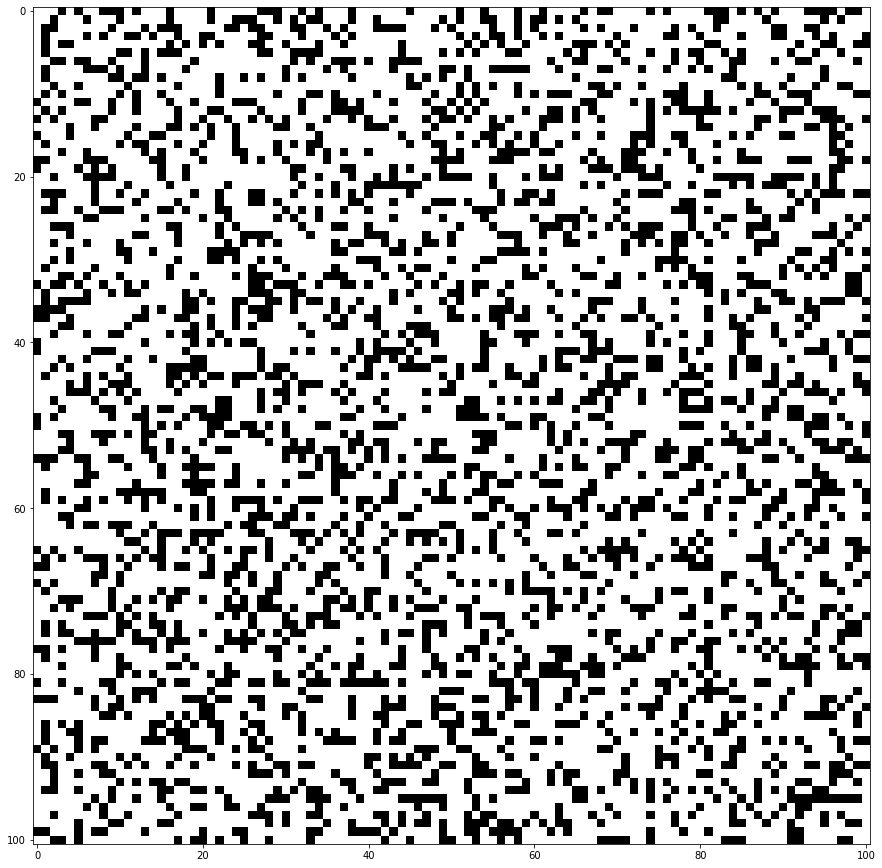

In [42]:
# generate and visualize the actual maze to solve
original_maze = Maze(maze_dims, maze_dims, 0.3)
original_maze.show_plot()

path finding example

In [43]:
# this subroutine makes a call to A* algorithm for path planning on mental maze
def call_astar(start, end, variant, tiebreak, g_values_prev):
    astar = AStar(mental_maze.grid, start, end, variant, tiebreak)
    return astar.search(g_values_prev)

In [44]:
# this function moves the agent between source and goal, 
# and visualizes its traversal
def solve_maze_with_visualization(
    source, goal, variant='forward', tiebreak='larger', g_values_prev={}):
    mental_maze_visualization.grid[goal[0]][goal[1]] = -2
    current = source

    path, num_expanded_nodes_latest, g_prev = call_astar(
        current, goal, variant, tiebreak, g_values_prev)
    
    num_expanded_nodes.append(num_expanded_nodes_latest)
    print('path', path)
    flag = 0

    if (path != None) and (len(path) > 0):
      for cell in path:
        if original_maze.is_blocked(cell[0], cell[1]):
          mental_maze.grid[cell[0]][cell[1]] = 1
          mental_maze_visualization.grid[cell[0]][cell[1]] = 1
          flag = 1
          break
        else:
          mental_maze_visualization.grid[cell[0]][cell[1]] = -1
          current = cell

      if flag == 1:
        mental_maze_visualization.show_plot()
        solve_maze_with_visualization(current, goal, variant, tiebreak, g_prev)
      else:
        mental_maze_visualization.grid[goal[0]][goal[1]] = -1
        return
    else:
      return

In [45]:
# set source and goal

start = (20,23)
end = (44,37)

source = original_maze.source(start[0], start[1])
print('source : ', source)
goal = original_maze.goal(end[0], end[1])
print('goal : ', goal)

source :  (20, 23)
goal :  (44, 37)


In [46]:
# generate mental maze for planning
mental_maze = Maze(maze_dims, maze_dims, 0)

# to keep track of updates to the mental maze and visualizing it
mental_maze_visualization = copy.deepcopy(mental_maze)
mental_maze_visualization.grid[source[0]][source[1]] = -2

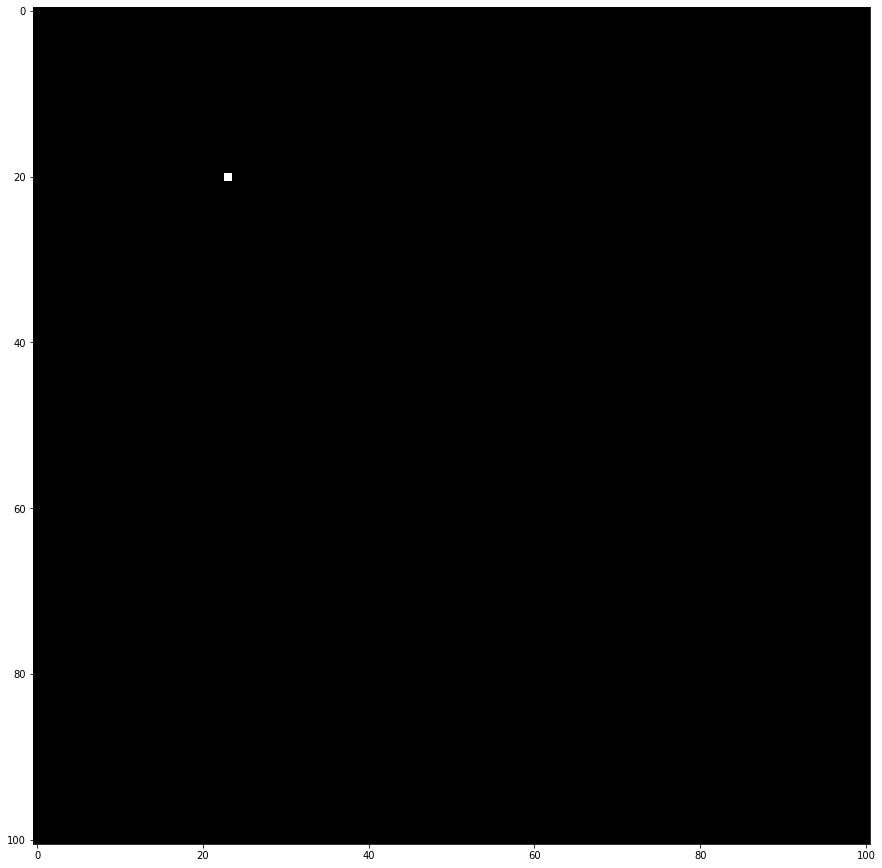

path [(20, 23), (20, 24), (20, 25), (20, 26), (20, 27), (20, 28), (20, 29), (20, 30), (20, 31), (20, 32), (20, 33), (20, 34), (20, 35), (20, 36), (20, 37), (21, 37), (22, 37), (23, 37), (24, 37), (25, 37), (26, 37), (27, 37), (28, 37), (29, 37), (30, 37), (31, 37), (32, 37), (33, 37), (34, 37), (35, 37), (36, 37), (37, 37), (38, 37), (39, 37), (40, 37), (41, 37), (42, 37), (43, 37)]


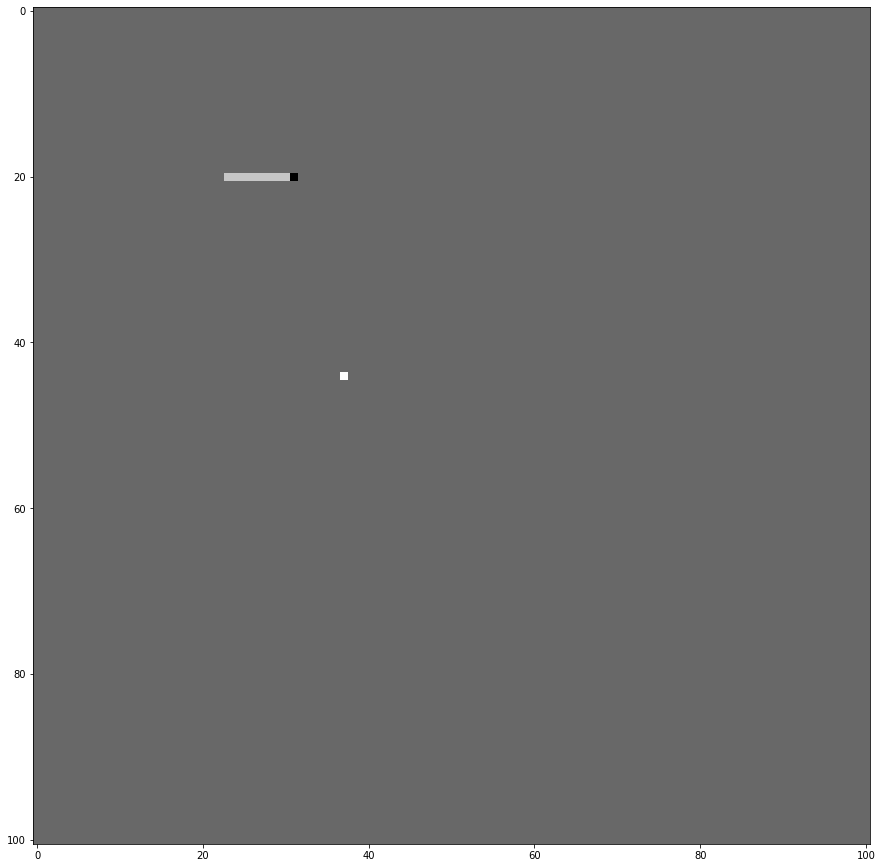

path [(20, 30), (21, 30), (21, 31), (21, 32), (21, 33), (21, 34), (21, 35), (21, 36), (21, 37), (22, 37), (23, 37), (24, 37), (25, 37), (26, 37), (27, 37), (28, 37), (29, 37), (30, 37), (31, 37), (32, 37), (33, 37), (34, 37), (35, 37), (36, 37), (37, 37), (38, 37), (39, 37), (40, 37), (41, 37), (42, 37), (43, 37)]


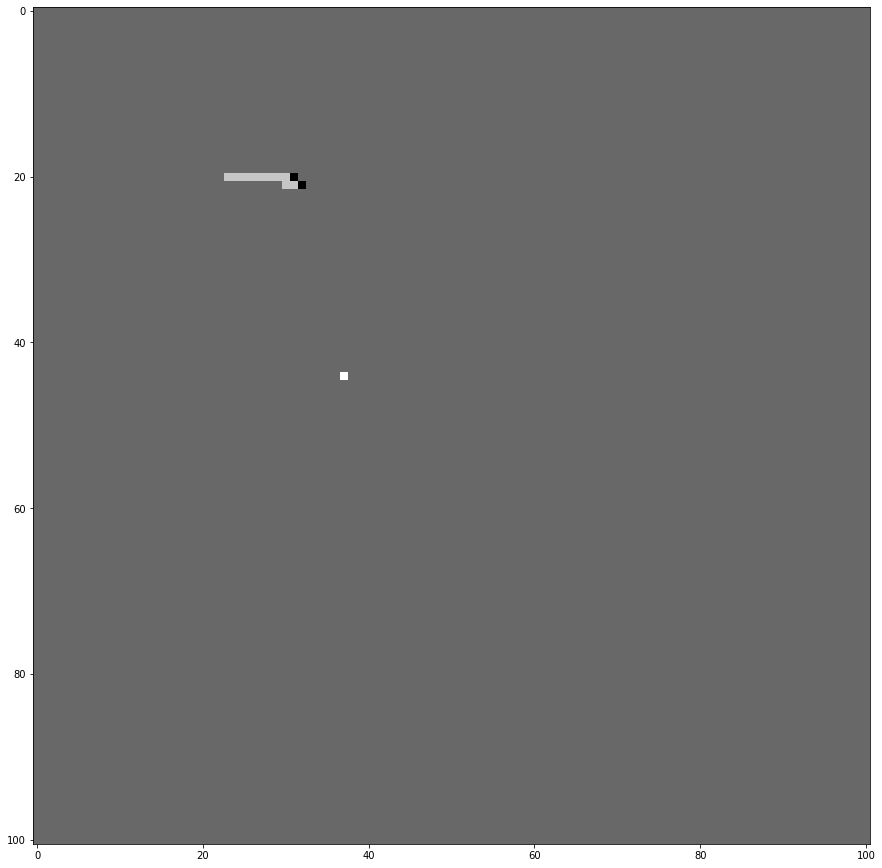

path [(21, 31), (22, 31), (22, 32), (22, 33), (22, 34), (22, 35), (22, 36), (22, 37), (23, 37), (24, 37), (25, 37), (26, 37), (27, 37), (28, 37), (29, 37), (30, 37), (31, 37), (32, 37), (33, 37), (34, 37), (35, 37), (36, 37), (37, 37), (38, 37), (39, 37), (40, 37), (41, 37), (42, 37), (43, 37)]


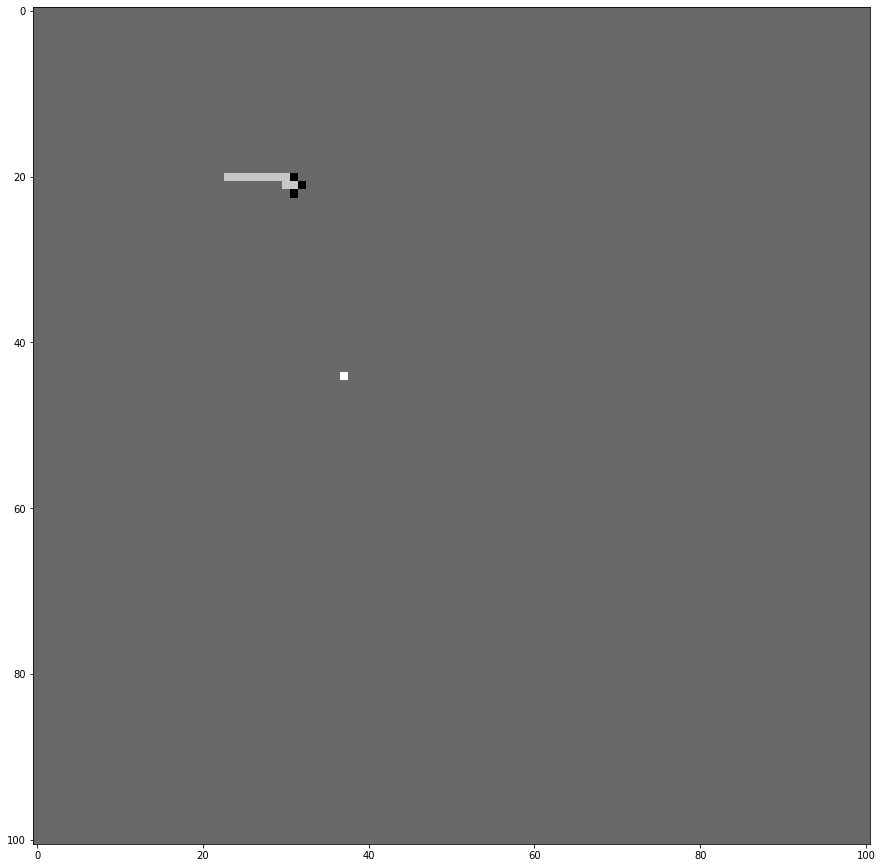

path [(21, 31), (21, 30), (22, 30), (23, 30), (23, 31), (23, 32), (23, 33), (23, 34), (23, 35), (23, 36), (23, 37), (24, 37), (25, 37), (26, 37), (27, 37), (28, 37), (29, 37), (30, 37), (31, 37), (32, 37), (33, 37), (34, 37), (35, 37), (36, 37), (37, 37), (38, 37), (39, 37), (40, 37), (41, 37), (42, 37), (43, 37)]


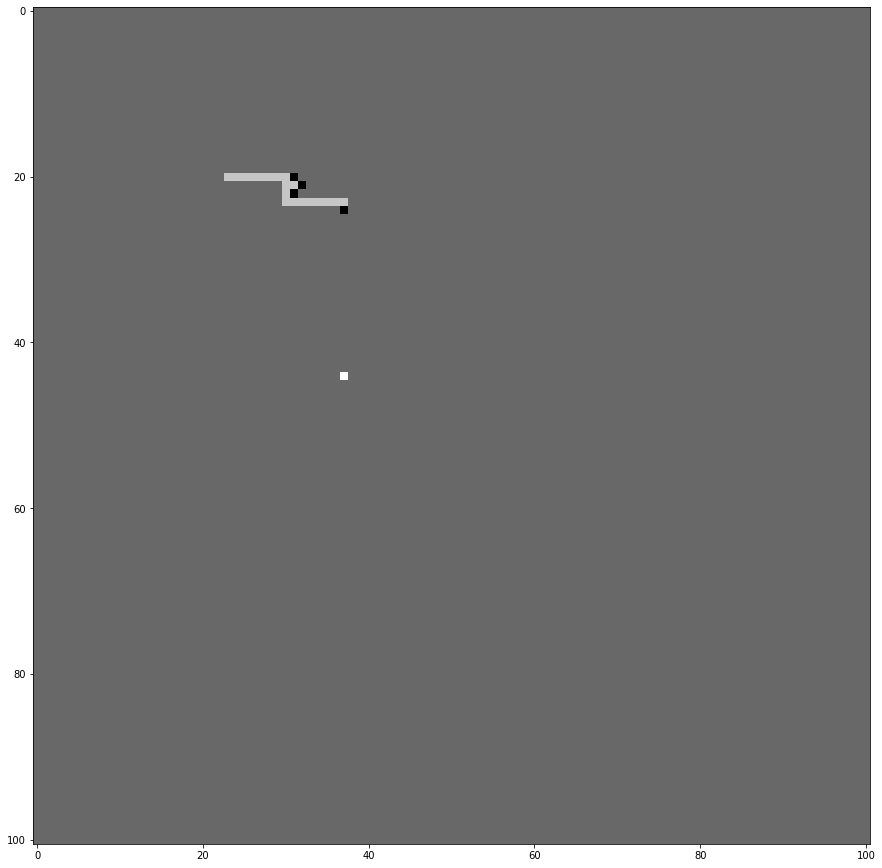

path [(23, 37), (23, 38), (24, 38), (25, 38), (25, 37), (26, 37), (27, 37), (28, 37), (29, 37), (30, 37), (31, 37), (32, 37), (33, 37), (34, 37), (35, 37), (36, 37), (37, 37), (38, 37), (39, 37), (40, 37), (41, 37), (42, 37), (43, 37)]


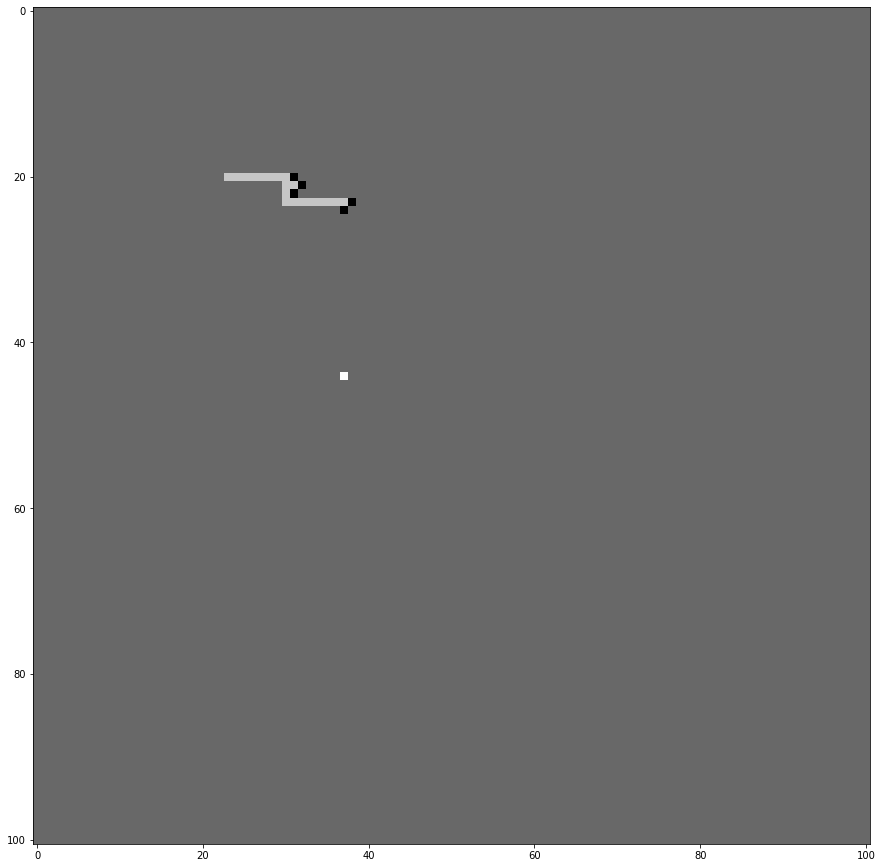

path [(23, 37), (23, 36), (24, 36), (25, 36), (25, 37), (26, 37), (27, 37), (28, 37), (29, 37), (30, 37), (31, 37), (32, 37), (33, 37), (34, 37), (35, 37), (36, 37), (37, 37), (38, 37), (39, 37), (40, 37), (41, 37), (42, 37), (43, 37)]


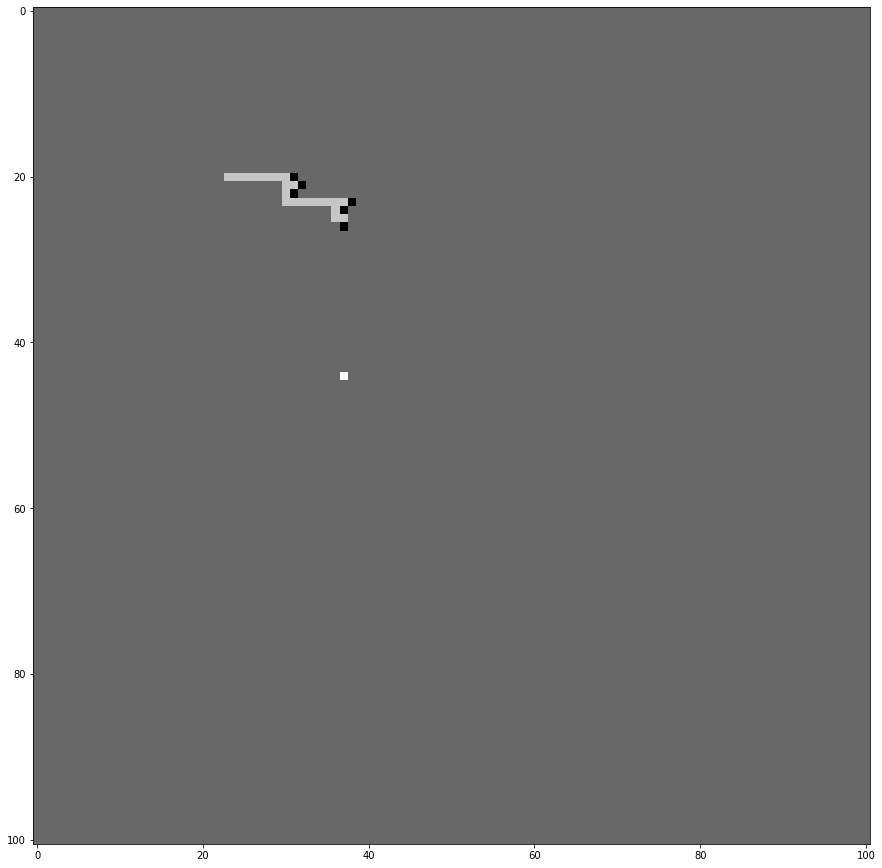

path [(25, 37), (25, 38), (26, 38), (27, 38), (27, 37), (28, 37), (29, 37), (30, 37), (31, 37), (32, 37), (33, 37), (34, 37), (35, 37), (36, 37), (37, 37), (38, 37), (39, 37), (40, 37), (41, 37), (42, 37), (43, 37)]


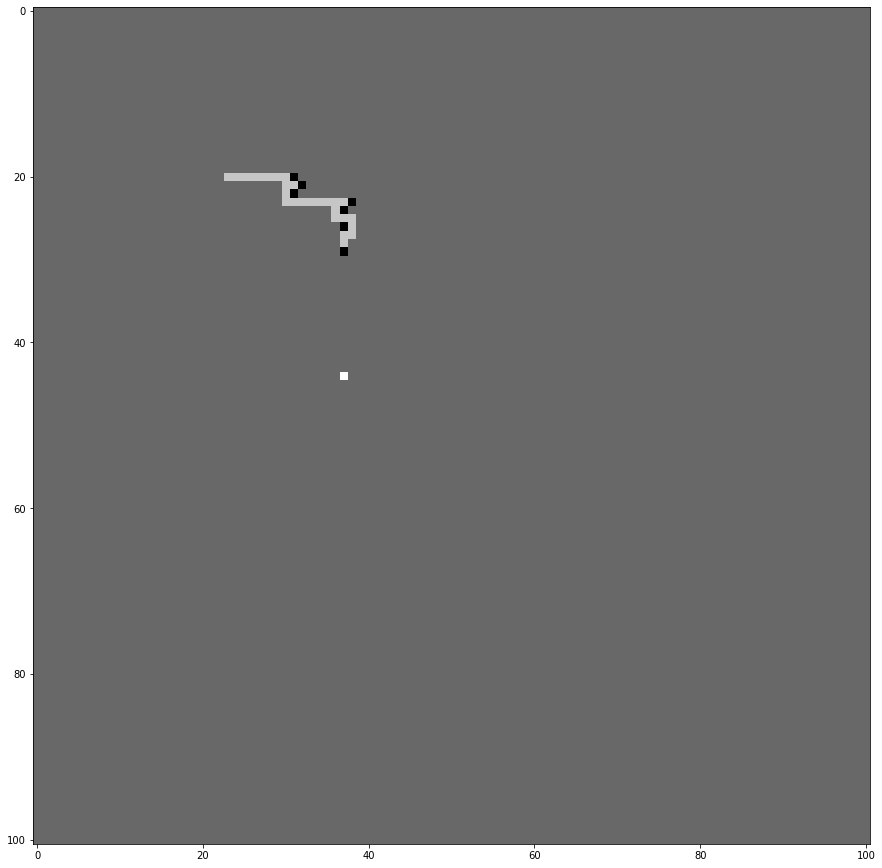

path [(28, 37), (28, 38), (29, 38), (30, 38), (30, 37), (31, 37), (32, 37), (33, 37), (34, 37), (35, 37), (36, 37), (37, 37), (38, 37), (39, 37), (40, 37), (41, 37), (42, 37), (43, 37)]


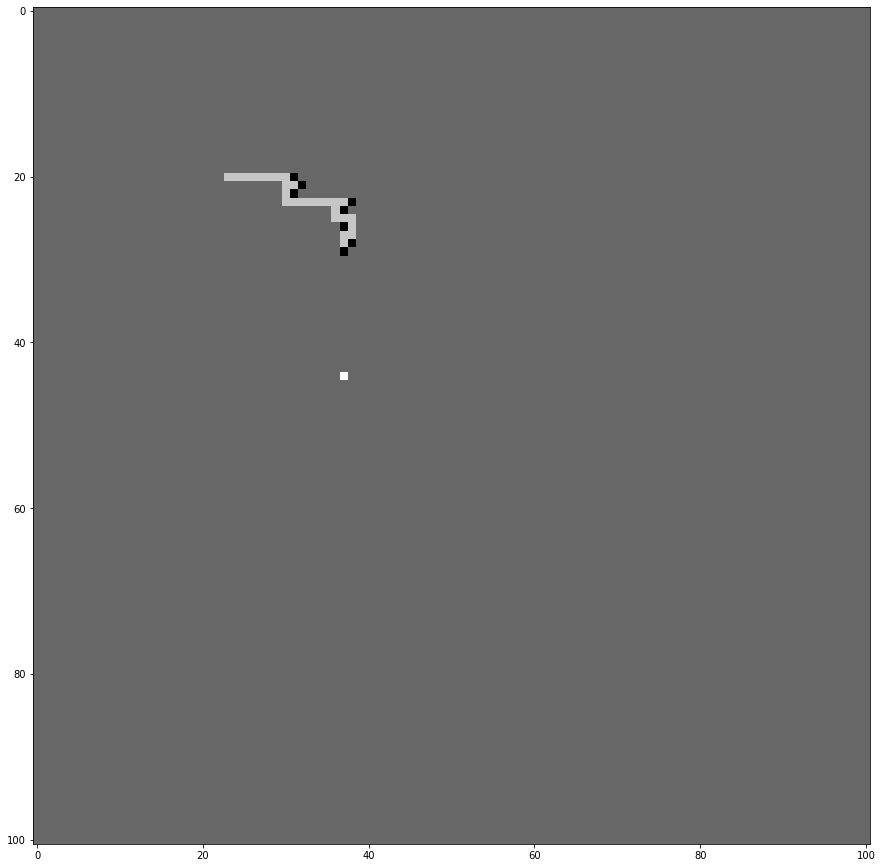

path [(28, 37), (28, 36), (29, 36), (30, 36), (30, 37), (31, 37), (32, 37), (33, 37), (34, 37), (35, 37), (36, 37), (37, 37), (38, 37), (39, 37), (40, 37), (41, 37), (42, 37), (43, 37)]


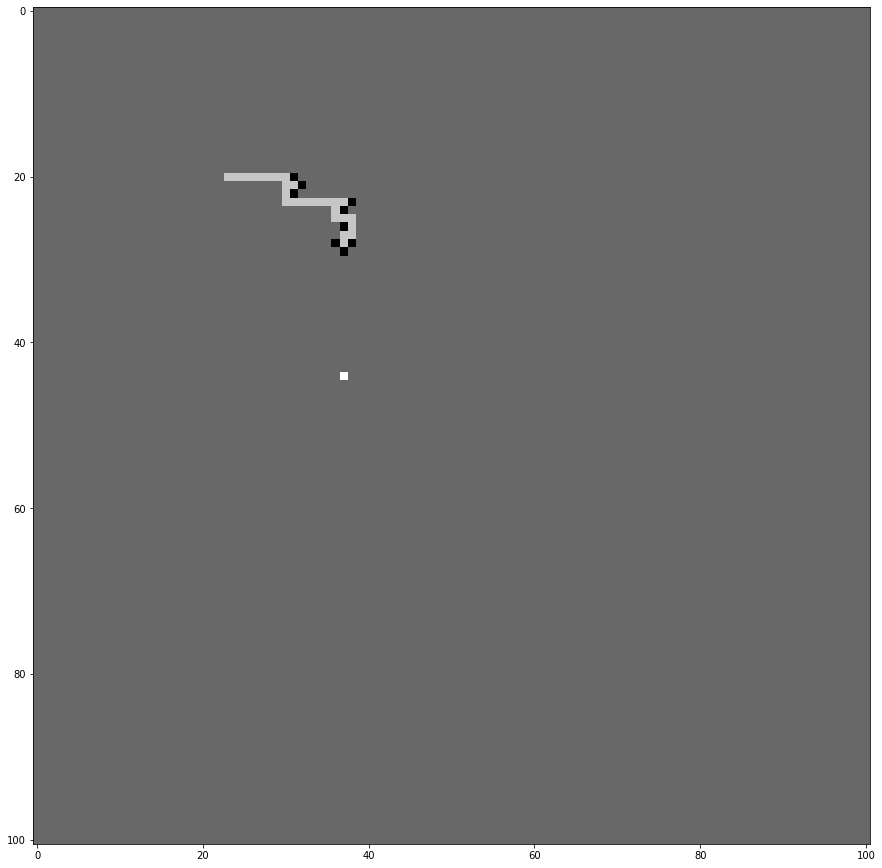

path [(28, 37), (27, 37), (27, 38), (27, 39), (28, 39), (29, 39), (29, 38), (30, 38), (30, 37), (31, 37), (32, 37), (33, 37), (34, 37), (35, 37), (36, 37), (37, 37), (38, 37), (39, 37), (40, 37), (41, 37), (42, 37), (43, 37)]


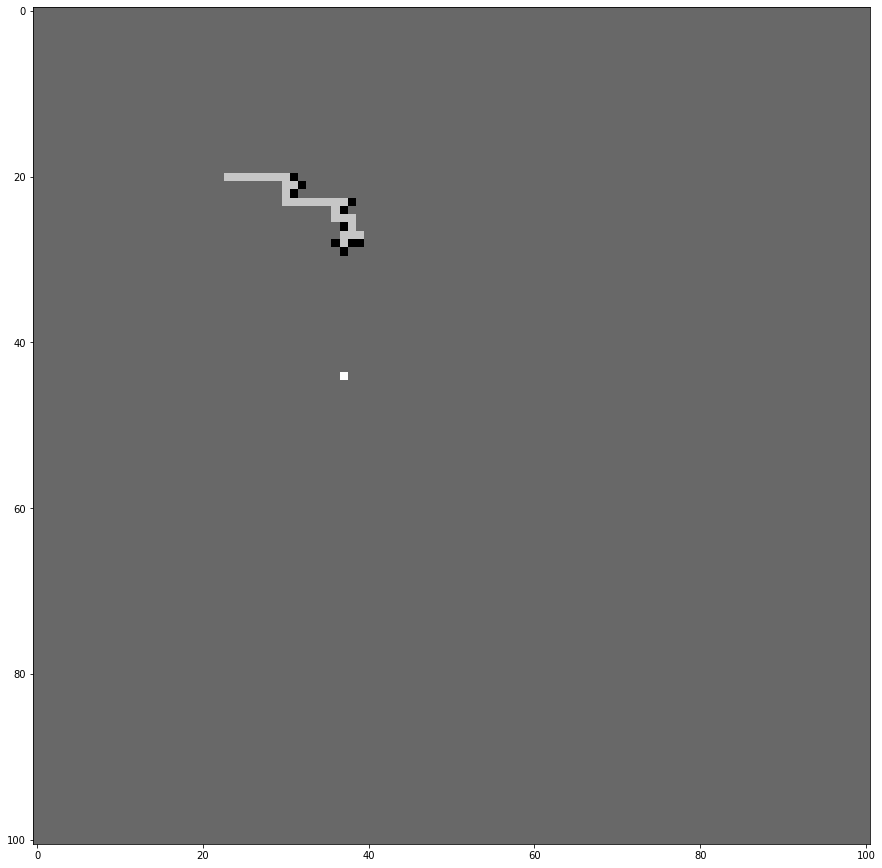

path [(27, 39), (27, 40), (28, 40), (29, 40), (29, 39), (29, 38), (30, 38), (30, 37), (31, 37), (32, 37), (33, 37), (34, 37), (35, 37), (36, 37), (37, 37), (38, 37), (39, 37), (40, 37), (41, 37), (42, 37), (43, 37)]


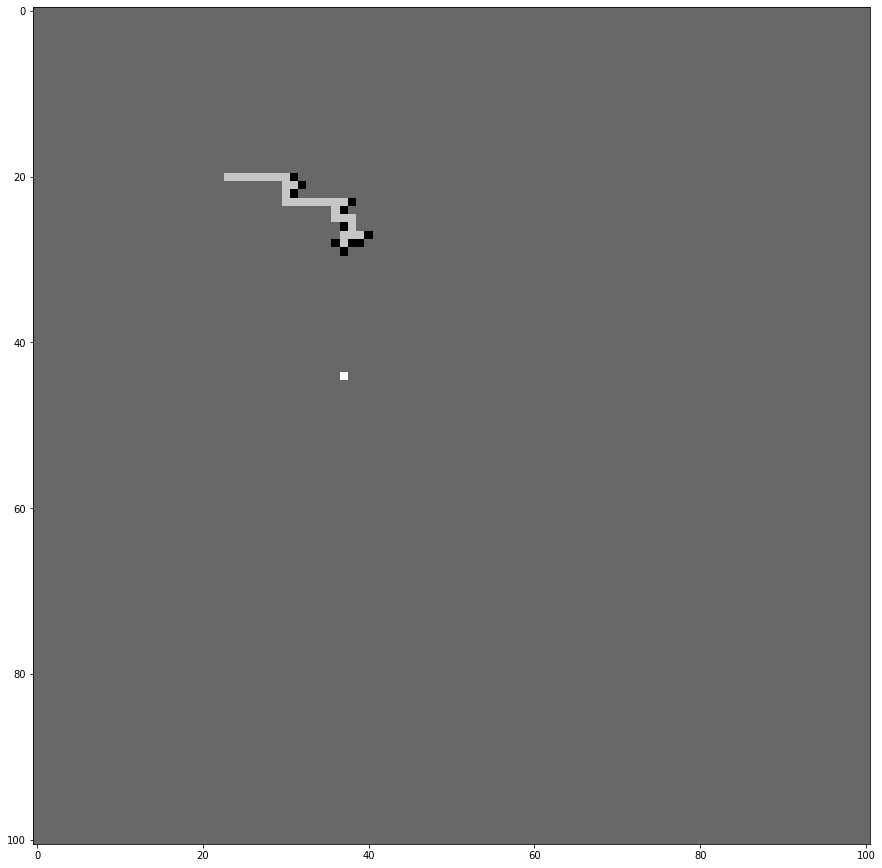

path [(27, 39), (27, 38), (27, 37), (27, 36), (27, 35), (28, 35), (29, 35), (29, 36), (30, 36), (30, 37), (31, 37), (32, 37), (33, 37), (34, 37), (35, 37), (36, 37), (37, 37), (38, 37), (39, 37), (40, 37), (41, 37), (42, 37), (43, 37)]


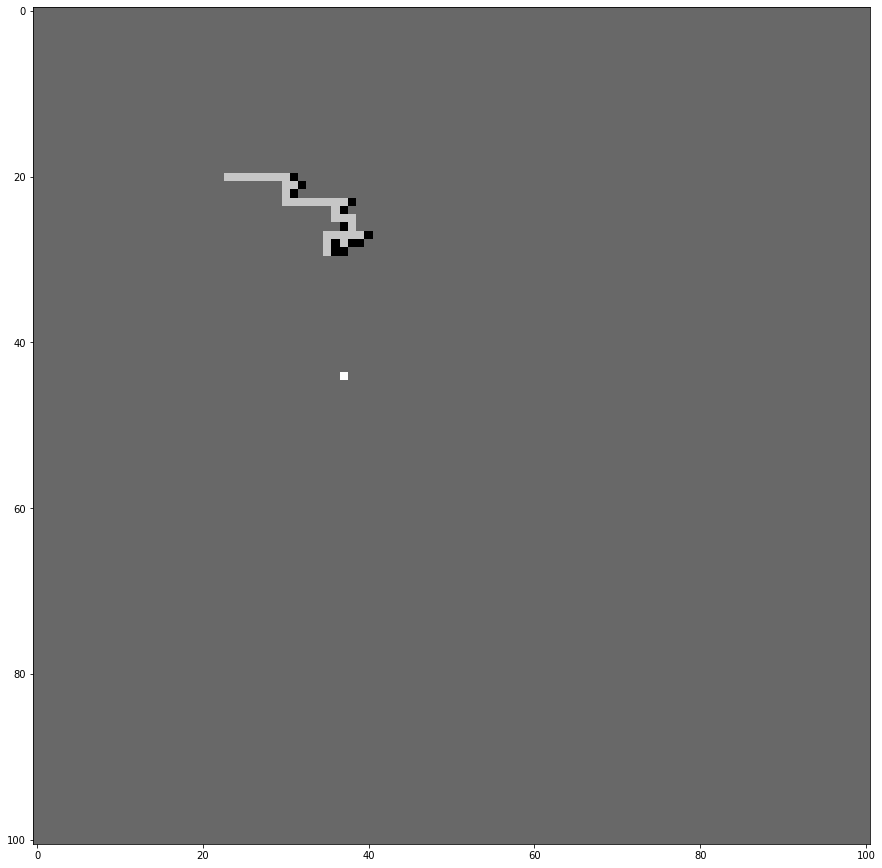

path [(29, 35), (30, 35), (30, 36), (30, 37), (31, 37), (32, 37), (33, 37), (34, 37), (35, 37), (36, 37), (37, 37), (38, 37), (39, 37), (40, 37), (41, 37), (42, 37), (43, 37)]


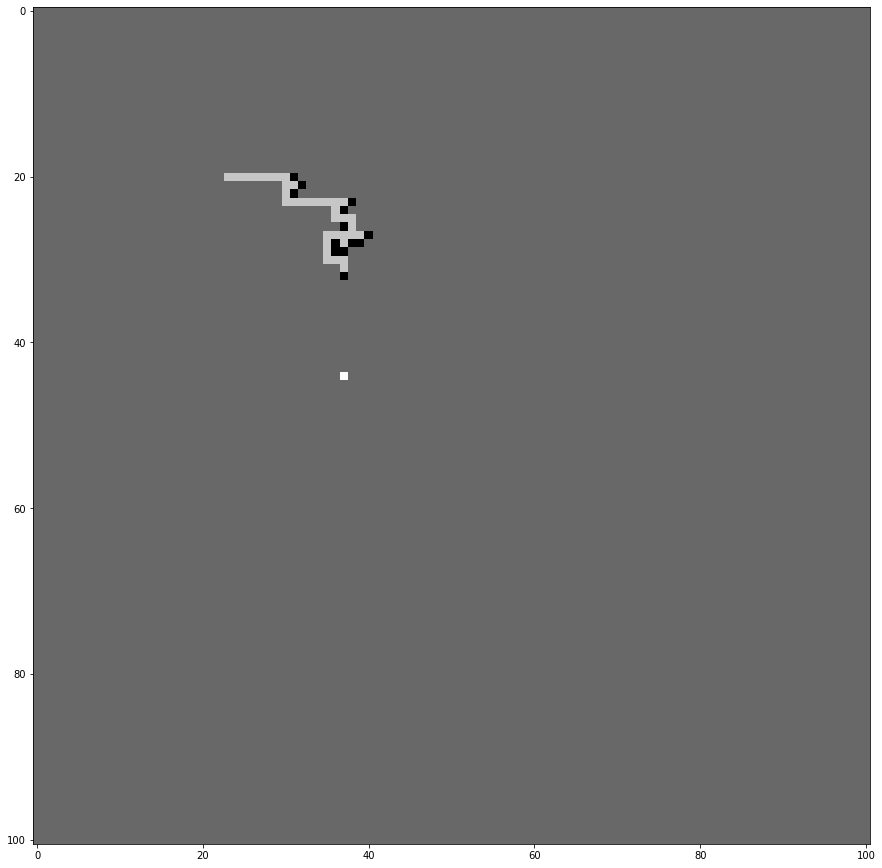

path [(31, 37), (31, 38), (32, 38), (33, 38), (33, 37), (34, 37), (35, 37), (36, 37), (37, 37), (38, 37), (39, 37), (40, 37), (41, 37), (42, 37), (43, 37)]


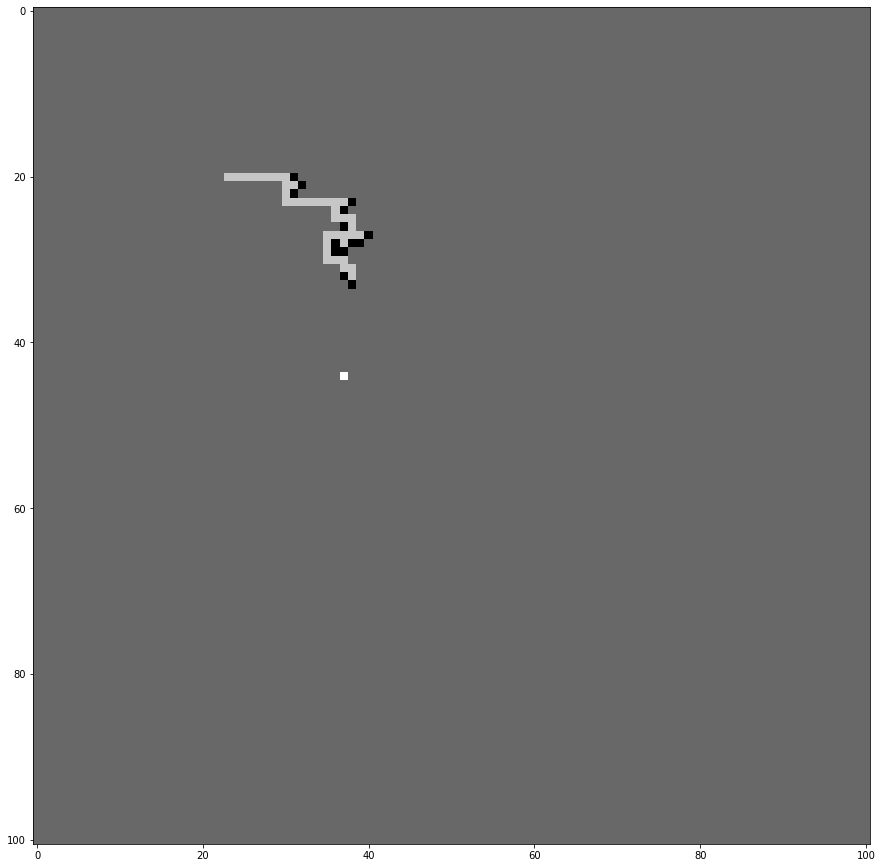

path [(32, 38), (32, 39), (33, 39), (34, 39), (34, 38), (34, 37), (35, 37), (36, 37), (37, 37), (38, 37), (39, 37), (40, 37), (41, 37), (42, 37), (43, 37)]


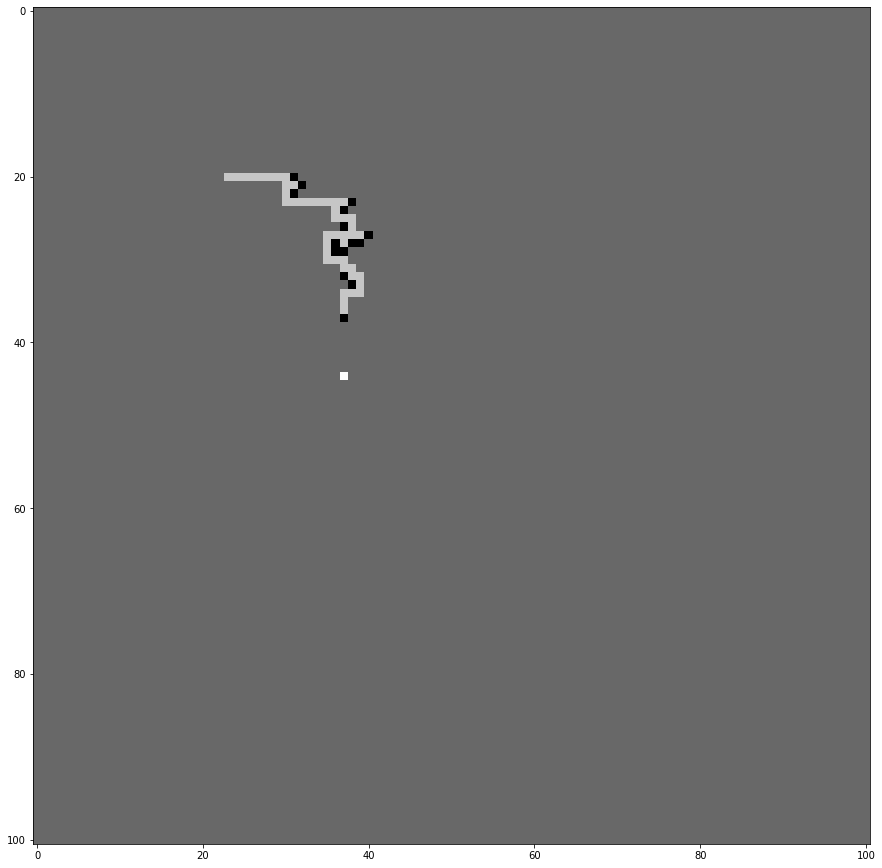

path [(36, 37), (36, 38), (37, 38), (38, 38), (38, 37), (39, 37), (40, 37), (41, 37), (42, 37), (43, 37)]


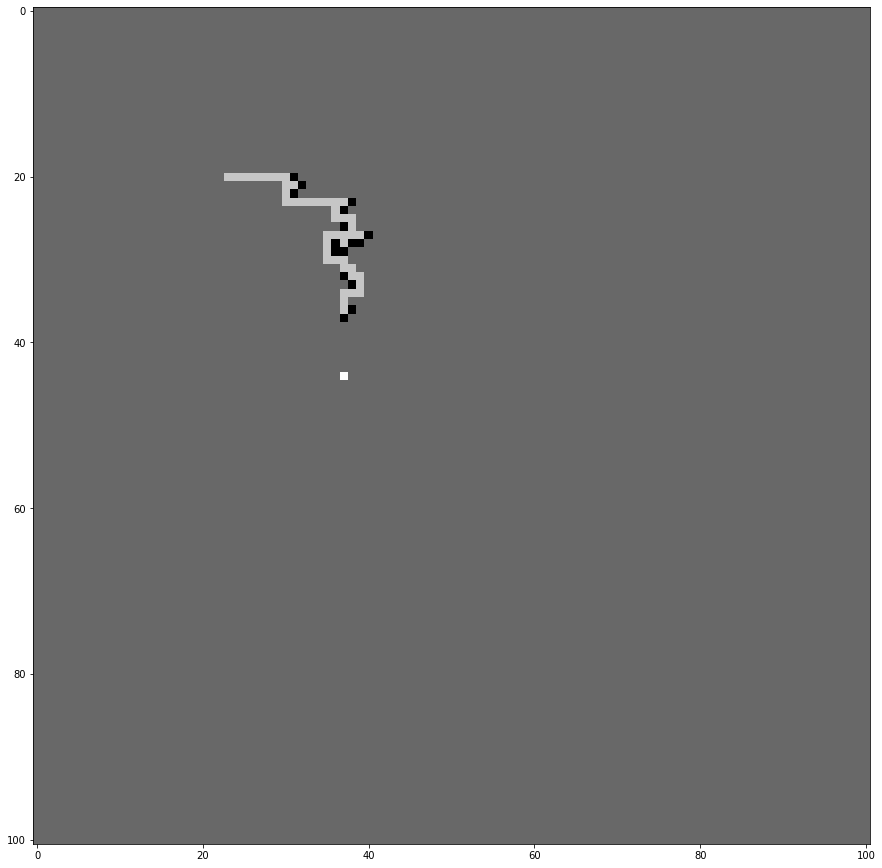

path [(36, 37), (36, 36), (37, 36), (38, 36), (38, 37), (39, 37), (40, 37), (41, 37), (42, 37), (43, 37)]


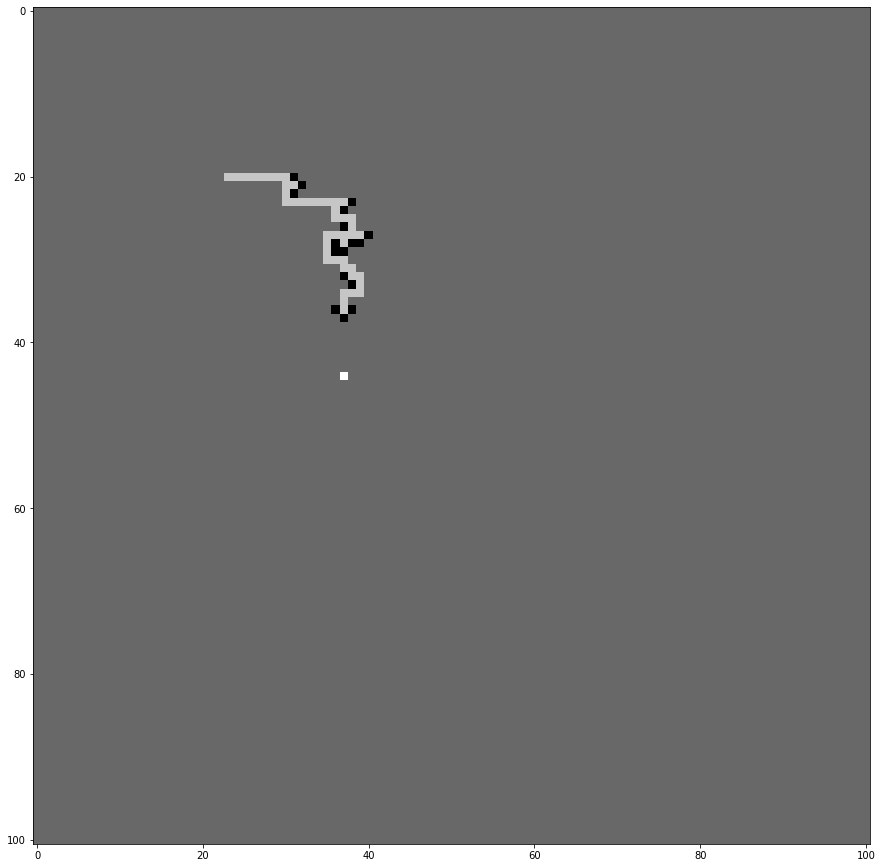

path [(36, 37), (35, 37), (35, 38), (35, 39), (36, 39), (37, 39), (37, 38), (38, 38), (38, 37), (39, 37), (40, 37), (41, 37), (42, 37), (43, 37)]


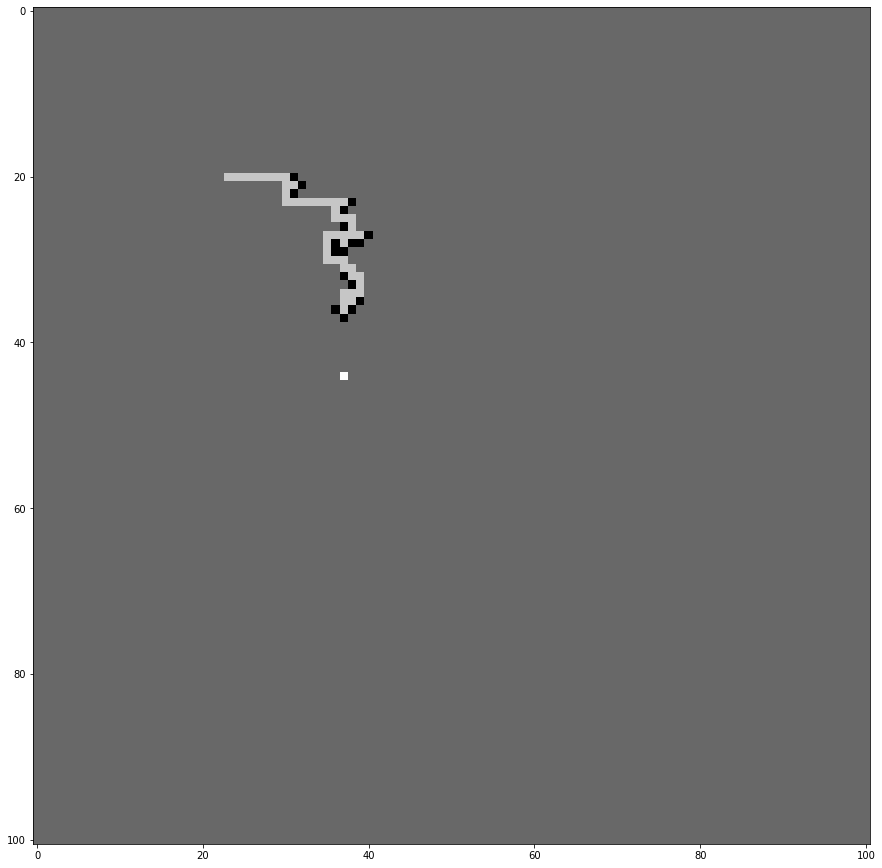

path [(35, 38), (35, 37), (35, 36), (35, 35), (36, 35), (37, 35), (37, 36), (38, 36), (38, 37), (39, 37), (40, 37), (41, 37), (42, 37), (43, 37)]


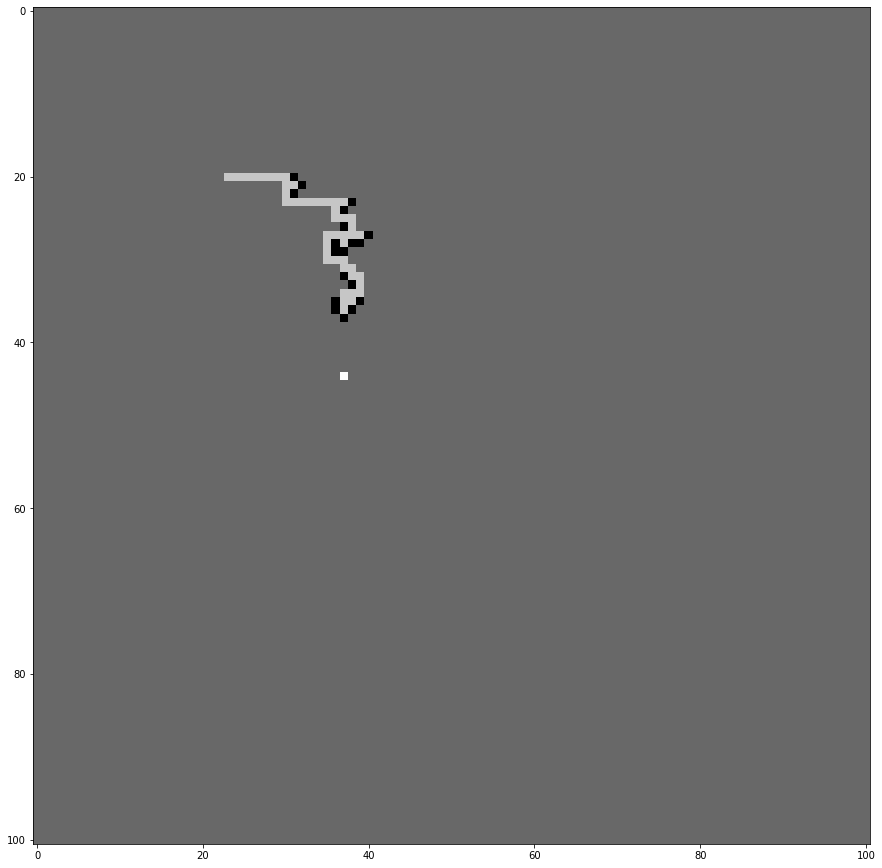

path [(35, 37), (34, 37), (34, 36), (34, 35), (35, 35), (36, 35), (37, 35), (37, 36), (38, 36), (38, 37), (39, 37), (40, 37), (41, 37), (42, 37), (43, 37)]


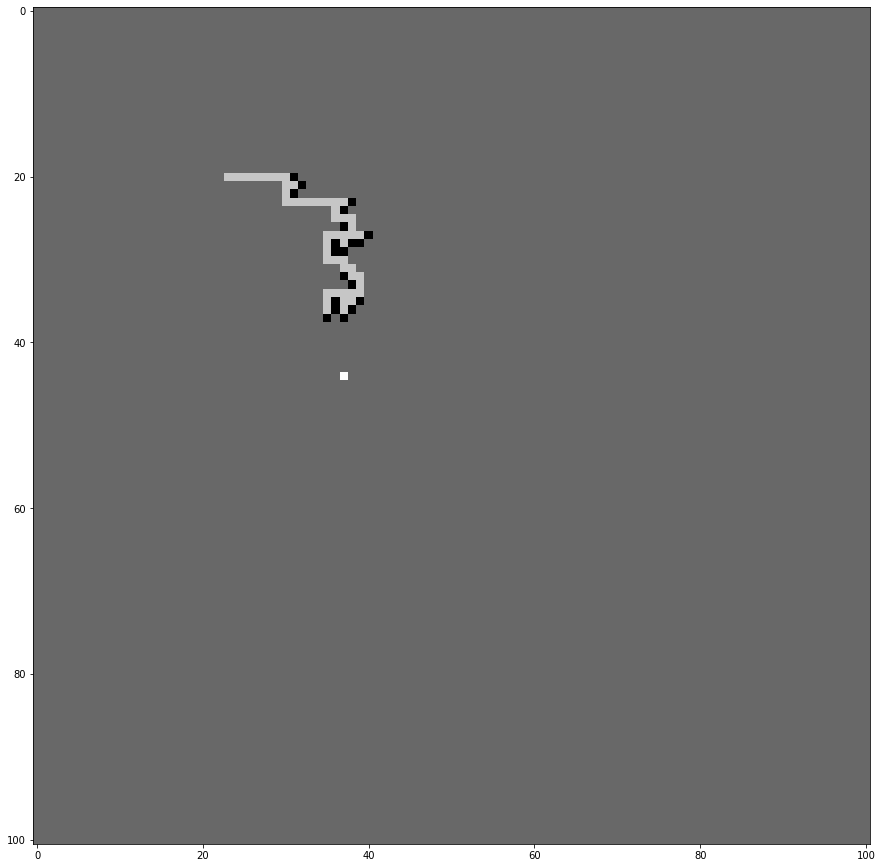

path [(36, 35), (36, 34), (37, 34), (38, 34), (38, 35), (38, 36), (38, 37), (39, 37), (40, 37), (41, 37), (42, 37), (43, 37)]


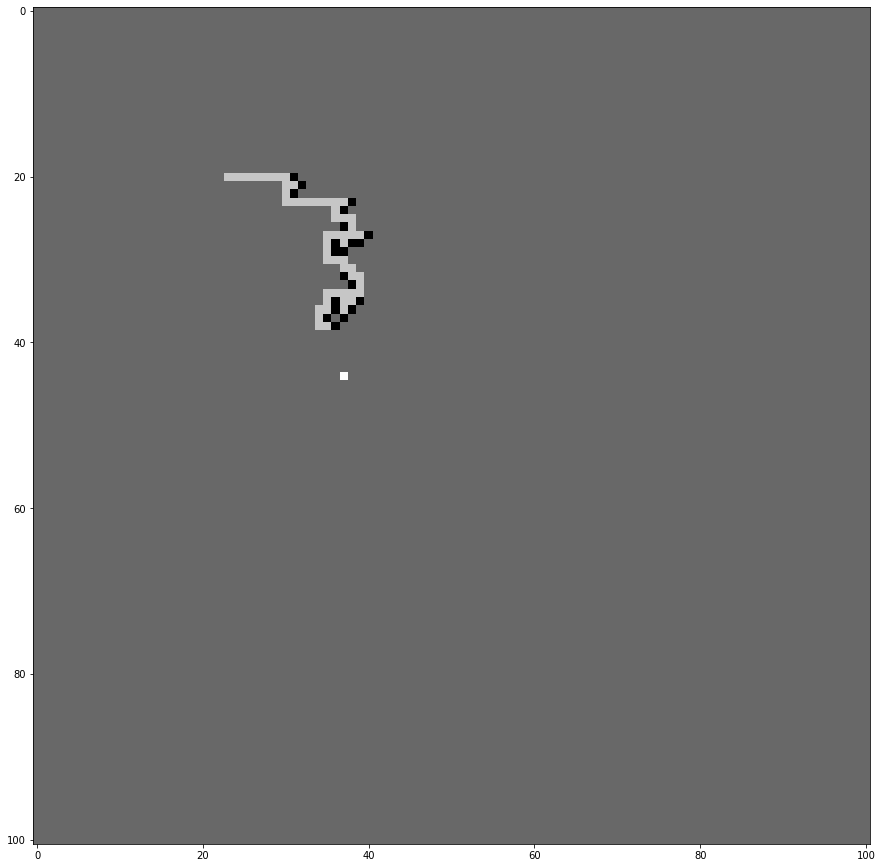

path [(38, 35), (39, 35), (39, 36), (39, 37), (40, 37), (41, 37), (42, 37), (43, 37)]


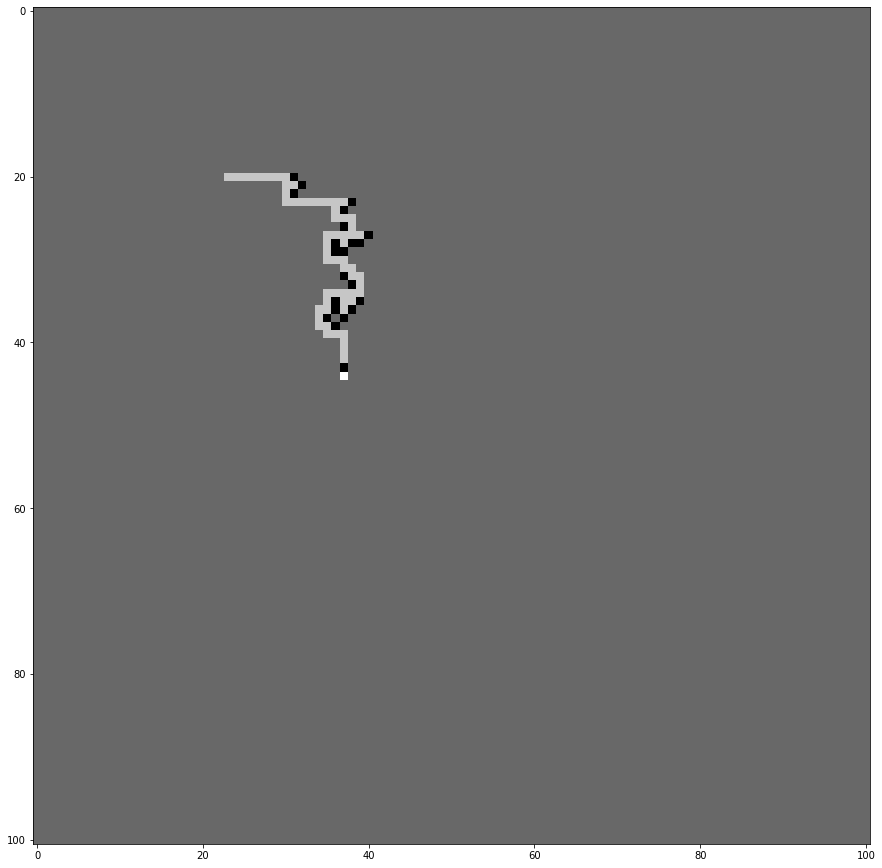

path [(42, 37), (42, 38), (43, 38), (44, 38)]


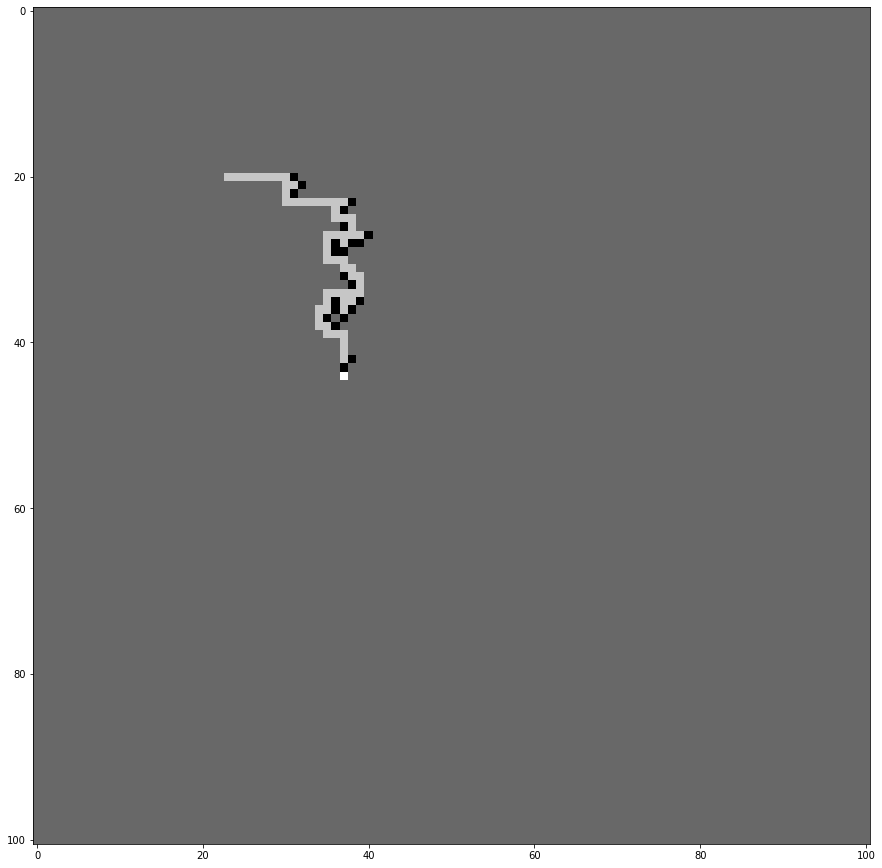

path [(42, 37), (42, 36), (43, 36), (44, 36)]


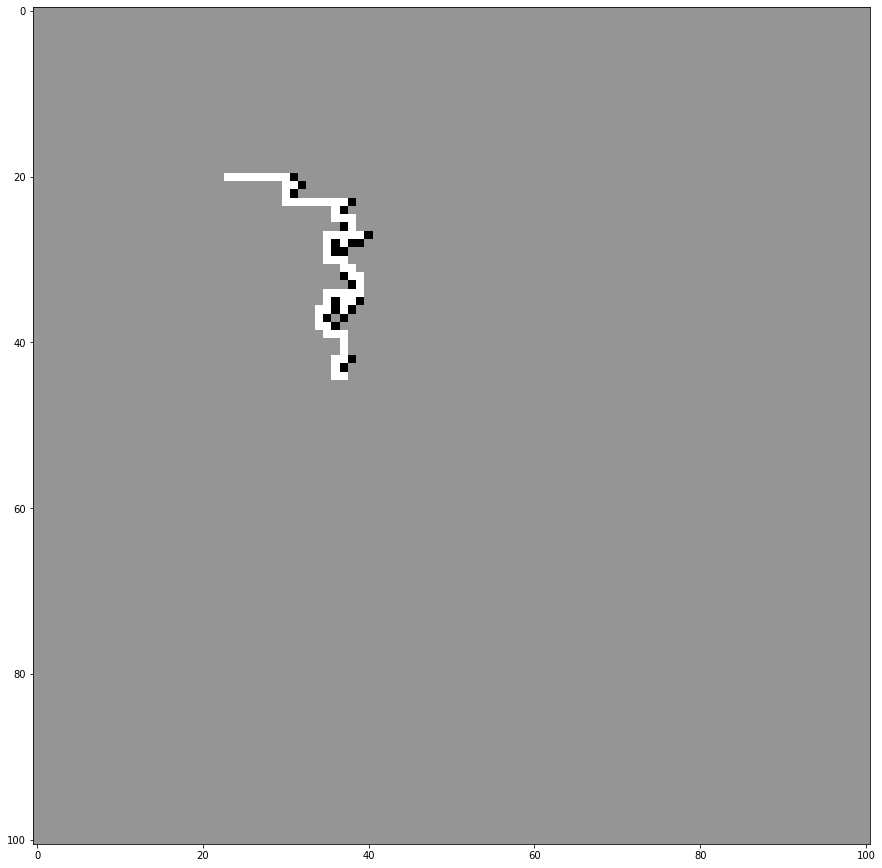

In [47]:
# maze solver call

mental_maze_visualization.show_plot()

num_expanded_nodes = []
solve_maze_with_visualization(source, goal)

mental_maze_visualization.show_plot()

In [48]:
# total number of nodes expanded by A* algorithm

if len(num_expanded_nodes) > 0:
  print('total number of nodes expanded by A* algorithm', sum(num_expanded_nodes))
else:
  print('the goal is not reachable from the given source')

total number of nodes expanded by A* algorithm 478


Experiments to evaluate different variations of A* algorithm

In [40]:
# this function moves the agent between source and goal
def solve_maze(
    source, goal, variant='forward', tiebreak='larger', g_values_prev={}):
    mental_maze_visualization.grid[goal[0]][goal[1]] = -2
    current = source

    path, num_expanded_nodes_latest, g_prev = call_astar(
        current, goal, variant, tiebreak, g_values_prev)
    
    num_expanded_nodes.append(num_expanded_nodes_latest)
    # print('path', path)
    flag = 0

    if (path != None) and (len(path) > 0):
      for cell in path:
        if original_maze.is_blocked(cell[0], cell[1]):
          mental_maze.grid[cell[0]][cell[1]] = 1
          flag = 1
          break
        else:
          current = cell

      if flag == 1:
        solve_maze(current, goal, variant, tiebreak, g_prev)
      else:
        return
    else:
      return

Experiment 1 : The Effects of Ties

In [57]:
num_experiments = []
run_time1 = []
run_time2 = []

for i in range(1, num_trials+1):
		print('trial', str(i))
		# randomly initialize source and goal states
		source = original_maze.source(random.randint(0,maze_dims-1), random.randint(0,maze_dims-1))
		print('source : ', source)
		goal = original_maze.goal(random.randint(0,maze_dims-1), random.randint(0,maze_dims-1))
		print('goal : ', goal)

		num_expanded_nodes = []
		# for tiebreaking between f-values, favor cells with larger g-values
		solve_maze(source, goal, tiebreak='larger')
		run_time1.append(sum(num_expanded_nodes))

		num_expanded_nodes = []
		# for tiebreaking between f-values, favor cells with smaller g-values
		solve_maze(source, goal, tiebreak='smaller')
		run_time2.append(sum(num_expanded_nodes))

		num_experiments.append(i)
		print('---------------------------------------------------------------')

trial 1
source coordinates correspond to a blocked cell, setting to default
source :  (0, 0)
goal :  (29, 65)
the desired goal is not reachable from the given source
the desired goal is not reachable from the given source
---------------------------------------------------------------
trial 2
source :  (22, 8)
goal :  (68, 9)
---------------------------------------------------------------
trial 3
source :  (50, 52)
goal coordinates correspond to a blocked cell, setting to default
goal :  (100, 100)
the desired goal is not reachable from the given source
the desired goal is not reachable from the given source
---------------------------------------------------------------
trial 4
source :  (44, 54)
goal :  (30, 34)
---------------------------------------------------------------
trial 5
source :  (18, 73)
goal :  (69, 41)
---------------------------------------------------------------
trial 6
source coordinates correspond to a blocked cell, setting to default
source :  (0, 0)
goal coordi

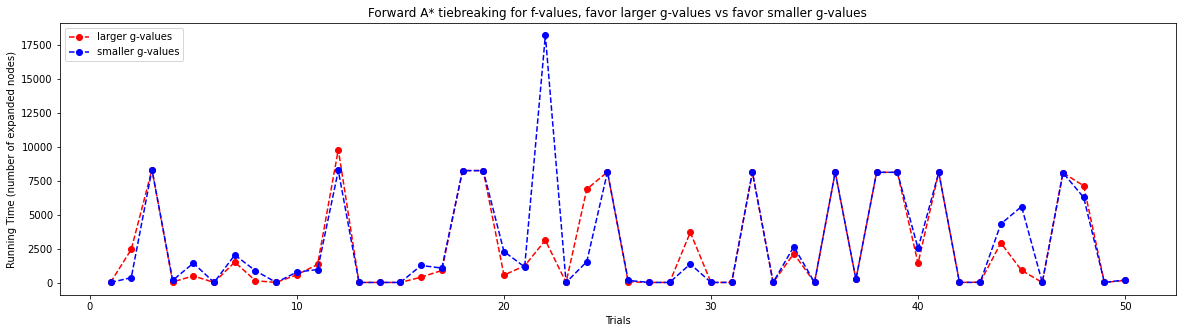

In [58]:
plt.figure(figsize=(20, 5))
lists1 = sorted(zip(*[num_experiments, run_time1]))
new_x1, new_y1 = list(zip(*lists1))
plt.plot(new_x1, new_y1, color='r', marker='o', linestyle='--', label='larger g-values')

lists2 = sorted(zip(*[num_experiments, run_time2]))
new_x2, new_y2 = list(zip(*lists2))
plt.plot(new_x2, new_y2, color='b', marker='o', linestyle='--', label='smaller g-values')

plt.xlabel('Trials')
plt.ylabel('Running Time (number of expanded nodes)')
plt.title("Forward A* tiebreaking for f-values, favor larger g-values vs favor smaller g-values")
plt.legend(['larger g-values', 'smaller g-values'], loc='upper left')
plt.show()

In [59]:
# larger g-values

print('avg number of nodes expanded for larger g-values', sum(run_time1)/num_trials)

avg number of nodes expanded for larger g-values 2605.16


In [60]:
# smaller g-values

print('avg number of nodes expanded for smaller g-values', sum(run_time2)/num_trials)

avg number of nodes expanded for smaller g-values 2917.54


Experiment 2 : Forward vs. Backward

In [53]:
num_experiments = []
run_time1 = []
run_time2 = []

for i in range(1, num_trials+1):
		print('trial', str(i))
		# randomly initialize source and goal states
		source = original_maze.source(random.randint(0,maze_dims-1), random.randint(0,maze_dims-1))
		print('source : ', source)
		goal = original_maze.goal(random.randint(0,maze_dims-1), random.randint(0,maze_dims-1))
		print('goal : ', goal)
	
		num_expanded_nodes = []
		# use repeated forward A*, favoring cells with larger g-values for ties in f-values
		solve_maze(source, goal, variant='forward')
		run_time1.append(sum(num_expanded_nodes))

		num_expanded_nodes = []
		# use repeated backward A*, favoring cells with larger g-values for ties in f-values
		solve_maze(source, goal, variant='backward')
		run_time2.append(sum(num_expanded_nodes))

		num_experiments.append(i)
		print('---------------------------------------------------------------')

trial 1
source :  (35, 60)
goal :  (100, 12)
---------------------------------------------------------------
trial 2
source coordinates correspond to a blocked cell, setting to default
source :  (0, 0)
goal :  (4, 87)
the desired goal is not reachable from the given source
the desired goal is not reachable from the given source
---------------------------------------------------------------
trial 3
source :  (84, 92)
goal :  (87, 47)
---------------------------------------------------------------
trial 4
source coordinates correspond to a blocked cell, setting to default
source :  (0, 0)
goal coordinates correspond to a blocked cell, setting to default
goal :  (100, 100)
the desired goal is not reachable from the given source
the desired goal is not reachable from the given source
---------------------------------------------------------------
trial 5
source :  (3, 69)
goal :  (6, 11)
---------------------------------------------------------------
trial 6
source :  (16, 47)
goal coordi

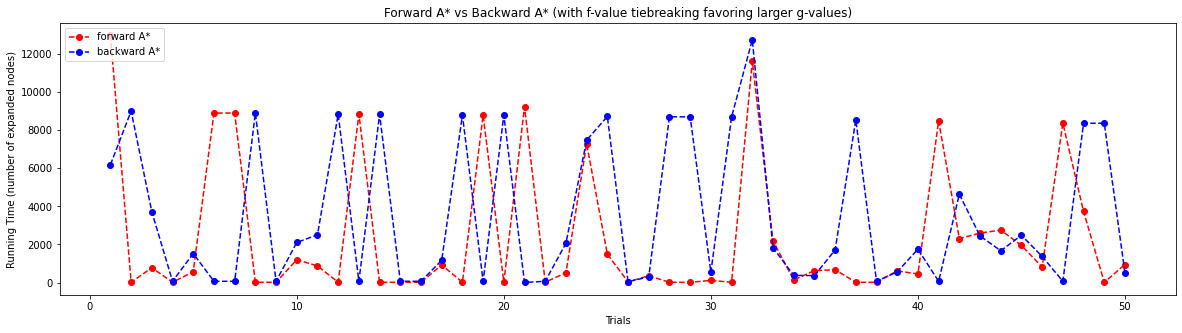

In [54]:
plt.figure(figsize=(20, 5))
lists1 = sorted(zip(*[num_experiments, run_time1]))
new_x1, new_y1 = list(zip(*lists1))
plt.plot(new_x1, new_y1, color='r', marker='o', linestyle='--', label='forward A*')

lists2 = sorted(zip(*[num_experiments, run_time2]))
new_x2, new_y2 = list(zip(*lists2))
plt.plot(new_x2, new_y2, color='b', marker='o', linestyle='--', label='backward A*')

plt.xlabel('Trials')
plt.ylabel('Running Time (number of expanded nodes)')
plt.title("Forward A* vs Backward A* (with f-value tiebreaking favoring larger g-values)")
plt.legend(['forward A*', 'backward A*'], loc='upper left')
plt.show()

In [55]:
# forward A*

print('avg number of nodes expanded for forward A*', sum(run_time1)/num_trials)

avg number of nodes expanded for forward A* 2404.82


In [56]:
# backward A*

print('avg number of nodes expanded for backward A*', sum(run_time2)/num_trials)

avg number of nodes expanded for backward A* 3479.92


Experiment 3 : Adaptive vs. Forward

In [49]:
num_experiments = []
run_time1 = []
run_time2 = []

for i in range(1, num_trials+1):
		print('trial', str(i))
		# randomly initialize source and goal states
		source = original_maze.source(random.randint(0,maze_dims-1), random.randint(0,maze_dims-1))
		print('source : ', source)
		goal = original_maze.goal(random.randint(0,maze_dims-1), random.randint(0,maze_dims-1))
		print('goal : ', goal)
	
		num_expanded_nodes = []
		# use adaptive A*, favoring cells with larger g-values for ties in f-values
		solve_maze(source, goal, variant='adaptive')
		run_time1.append(sum(num_expanded_nodes))

		num_expanded_nodes = []
		# use repeated backward A*, favoring cells with larger g-values for ties in f-values
		solve_maze(source, goal, variant='forward')
		run_time2.append(sum(num_expanded_nodes))

		num_experiments.append(i)
		print('---------------------------------------------------------------')

trial 1
source :  (80, 2)
goal :  (55, 32)
---------------------------------------------------------------
trial 2
source coordinates correspond to a blocked cell, setting to default
source :  (0, 0)
goal :  (9, 18)
the desired goal is not reachable from the given source
the desired goal is not reachable from the given source
---------------------------------------------------------------
trial 3
source :  (83, 83)
goal :  (70, 12)
---------------------------------------------------------------
trial 4
source coordinates correspond to a blocked cell, setting to default
source :  (0, 0)
goal :  (88, 68)
the desired goal is not reachable from the given source
the desired goal is not reachable from the given source
---------------------------------------------------------------
trial 5
source coordinates correspond to a blocked cell, setting to default
source :  (0, 0)
goal coordinates correspond to a blocked cell, setting to default
goal :  (100, 100)
the desired goal is not reachable fr

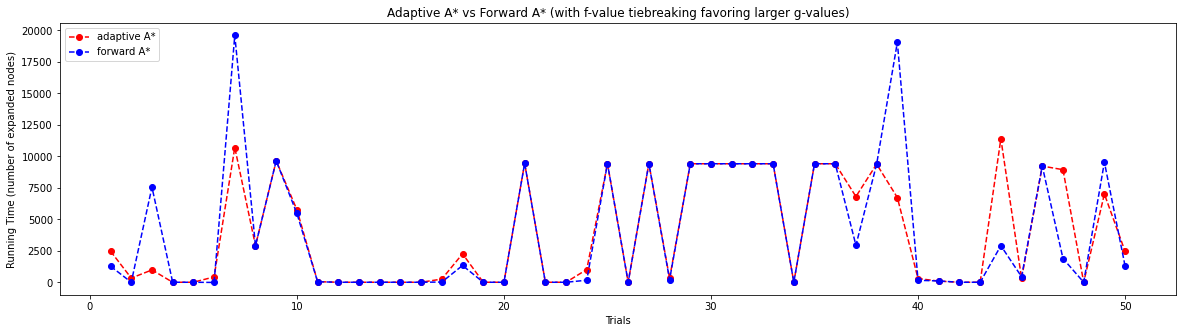

In [50]:
plt.figure(figsize=(20, 5))
lists1 = sorted(zip(*[num_experiments, run_time1]))
new_x1, new_y1 = list(zip(*lists1))
plt.plot(new_x1, new_y1, color='r', marker='o', linestyle='--', label='adaptive A*')

lists2 = sorted(zip(*[num_experiments, run_time2]))
new_x2, new_y2 = list(zip(*lists2))
plt.plot(new_x2, new_y2, color='b', marker='o', linestyle='--', label='forward A*')

plt.xlabel('Trials')
plt.ylabel('Running Time (number of expanded nodes)')
plt.title("Adaptive A* vs Forward A* (with f-value tiebreaking favoring larger g-values)")
plt.legend(['adaptive A*', 'forward A*'], loc='upper left')
plt.show()

In [51]:
# adaptive A*

print('avg number of nodes expanded for adaptive A*', sum(run_time1)/num_trials)

avg number of nodes expanded for adaptive A* 3891.74


In [52]:
# forward A*

print('avg number of nodes expanded for forward A*', sum(run_time2)/num_trials)

avg number of nodes expanded for forward A* 3998.76
